In [1]:
# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd

# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")

In [3]:
pob = pd.read_excel('Poblacion.xlsx')

In [4]:
#Convertimos a formato de fecha
pob['Date'] = pd.to_datetime(pob['Date'],format='%Y')
pob = pob.set_index('Date')

In [6]:
#Verificamos que no existan valores nulos
print(f"Valores missing: {pob.isnull().any(axis=1).sum()}")

Valores missing: 0


In [7]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [9]:
Prueba_Dickey_Fuller(pob['America_latina'],"America_latina")

Resultados de la prueba de Dickey-Fuller para columna: America_latina
Test Statistic                         0.608087
p-value                                0.987813
No Lags Used                           1.000000
Número de observaciones utilizadas    59.000000
Critical Value (1%)                   -3.546395
Critical Value (5%)                   -2.911939
Critical Value (10%)                  -2.593652
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


In [10]:
df1=pob.copy()
# Take first difference
df1['Migraciones_diff'] = pob['America_latina'].diff()

# Remove the first data point
df1.dropna(inplace=True)

# Take a look at the head of the dataset
df1.head()

,America_latina,Migraciones_diff
Date,,
1962-01-01,2.811273,-0.000588
1963-01-01,2.801514,-0.009759
1964-01-01,2.777553,-0.023962
1965-01-01,2.744166,-0.033387
1966-01-01,2.691135,-0.053031


In [12]:
Prueba_Dickey_Fuller(df1['Migraciones_diff'],"Migraciones_diff")

Resultados de la prueba de Dickey-Fuller para columna: Migraciones_diff
Test Statistic                        -3.888137
p-value                                0.002124
No Lags Used                           9.000000
Número de observaciones utilizadas    50.000000
Critical Value (1%)                   -3.568486
Critical Value (5%)                   -2.921360
Critical Value (10%)                  -2.598662
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


### División de la data

In [13]:
train_mig = pob[:len(pob)]
test_mig = pob[len(pob)-12:]
test=test_mig.copy()

In [14]:
train_mig.shape, test_mig.shape

((61, 1), (12, 1))

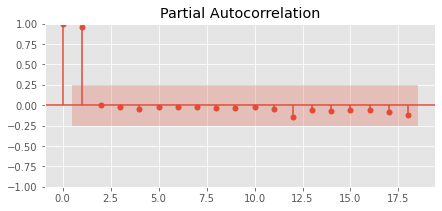

In [17]:
# Gráfico autocorrelación parcial

fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(pob['America_latina'], ax=ax)
plt.show()

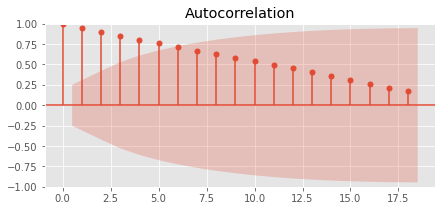

In [18]:
# Gráfico autocorrelación

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(pob['America_latina'], ax=ax)
plt.show()

In [19]:
# Modelo Auto-Arima
from pmdarima import auto_arima 

In [20]:
modelo_auto=auto_arima(train_mig,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=1, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=10)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-268.879, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-274.890, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-274.553, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-204.374, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-273.057, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-273.062, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-271.053, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-263.023, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.387 seconds
 ARIMA(1,1,0)(0,0,0)[0] intercept


In [21]:
print(modelo_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 140.445
Date:                Wed, 01 Mar 2023   AIC                           -274.890
Time:                        11:23:56   BIC                           -268.607
Sample:                    01-01-1961   HQIC                          -272.432
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0216      0.007     -3.003      0.003      -0.036      -0.007
ar.L1          0.4026      0.136      2.953      0.003       0.135       0.670
sigma2         0.0005    4.5e-05     12.027      0.0

In [22]:
arima_model = SARIMAX(train_mig["America_latina"], order = (1,1,0), seasonal_order = (0,0,0,0)) 
arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         America_latina   No. Observations:                   61
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 133.512
Date:                Wed, 01 Mar 2023   AIC                           -263.023
Time:                        11:24:15   BIC                           -258.834
Sample:                    01-01-1961   HQIC                          -261.385
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8476      0.072     11.736      0.000       0.706       0.989
sigma2         0.0007      7e-05      9.552      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   3.25   Jarque-Bera (JB):               220.32
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               4.98   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

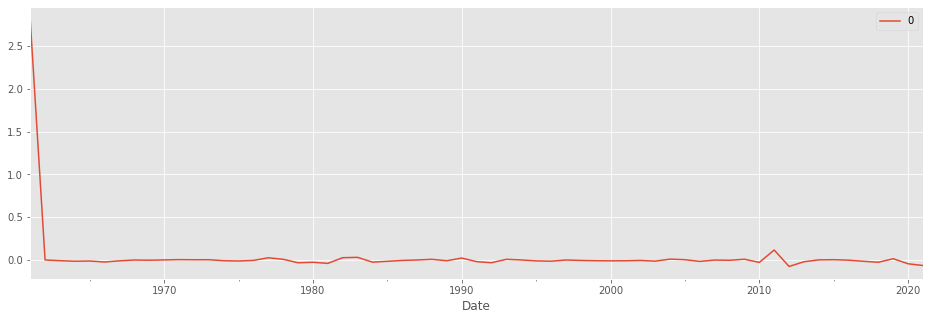

In [23]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

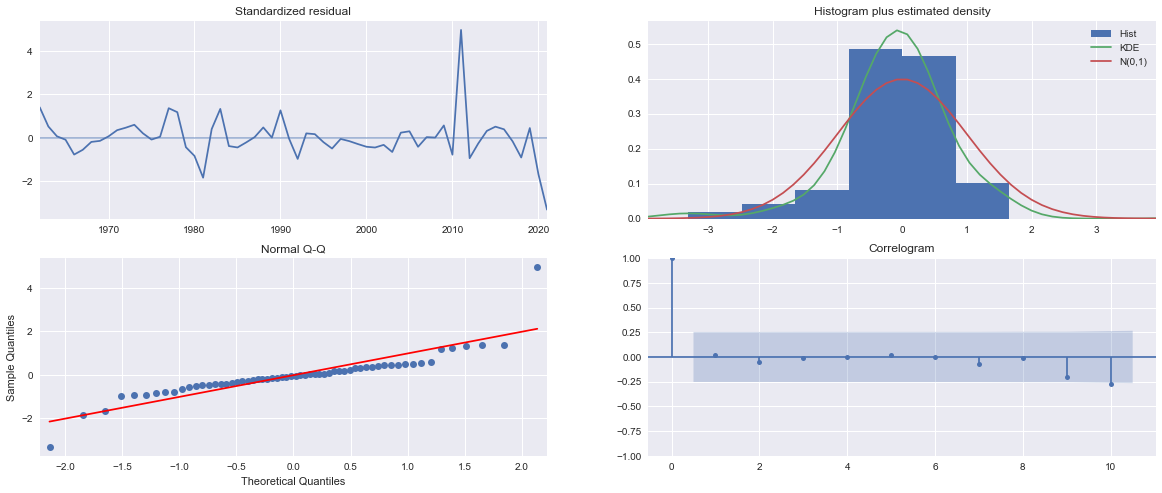

In [24]:
plt.style.use('seaborn')
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

In [25]:
arima_pred2 = arima_result.predict(start='1970-01-01',end='2025-01-01', typ="levels").rename("ARIMA Predictions")
arima_pred2

1970-01-01    2.504454
1971-01-01    2.471885
1972-01-01    2.450867
1973-01-01    2.433790
1974-01-01    2.421854
1975-01-01    2.392440
1976-01-01    2.351353
1977-01-01    2.316881
1978-01-01    2.338868
1979-01-01    2.349864
1980-01-01    2.290808
1981-01-01    2.218061
1982-01-01    2.104695
1983-01-01    2.090874
1984-01-01    2.112820
1985-01-01    2.057405
1986-01-01    2.001844
1987-01-01    1.957339
1988-01-01    1.923412
1989-01-01    1.907919
1990-01-01    1.870984
1991-01-01    1.888497
1992-01-01    1.847316
1993-01-01    1.768108
1994-01-01    1.742447
1995-01-01    1.713615
1996-01-01    1.668411
1997-01-01    1.611293
1998-01-01    1.574119
1999-01-01    1.531938
2000-01-01    1.483972
2001-01-01    1.430972
2002-01-01    1.376871
2003-01-01    1.328298
2004-01-01    1.265446
2005-01-01    1.241494
2006-01-01    1.218408
2007-01-01    1.163757
2008-01-01    1.129591
2009-01-01    1.094044
2010-01-01    1.082281
2011-01-01    1.011306
2012-01-01    1.189644
2013-01-01 

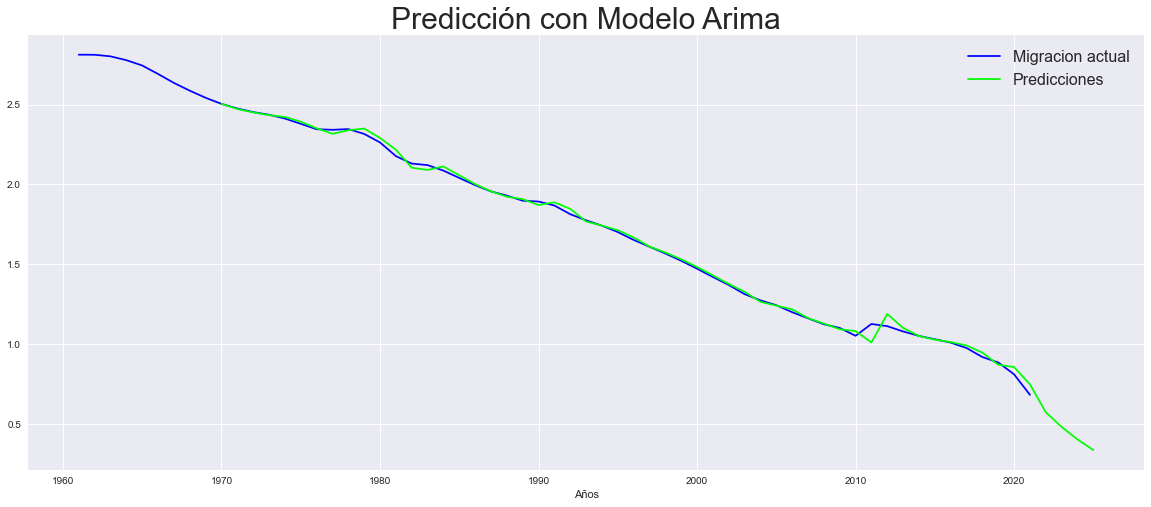

In [27]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(train_mig["America_latina"],color="blue" ,label="Migracion actual")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Años')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [28]:
arima_pred = arima_result.predict(start='2010-01-01',end='2021-01-01', typ="levels").rename("ARIMA Predictions")
arima_pred

2010-01-01    1.082281
2011-01-01    1.011306
2012-01-01    1.189644
2013-01-01    1.101622
2014-01-01    1.051755
2015-01-01    1.028788
2016-01-01    1.013645
2017-01-01    0.992584
2018-01-01    0.947652
2019-01-01    0.872202
2020-01-01    0.857304
2021-01-01    0.749031
Freq: AS-JAN, Name: ARIMA Predictions, dtype: float64

In [29]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [30]:
evaluacion_metrica(test_mig,arima_pred)

Evaluation metric results:-
MSE is : 0.002343452362267791
MAE is : 0.034829614361185646
RMSE is : 0.0484092177407133
MAPE is : 14.778420223022698
R2 is : 0.8535200202636418

